## Time Series-Sentiment forecasting

### Importing libraries

In [ ]:
# import libraries
import numpy as np
import pandas as pd

#decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# dickey fuller test for stationarity
from statsmodels.tsa.stattools import acf,pacf,adfuller

# ARIMA
from statsmodels.tsa.arima.model import ARIMA

# plots
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error

# Ljung-Box test for model goodness
import statsmodels.api as sm
# resampling
from sklearn.utils import resample

import warnings
warnings.filterwarnings("ignore")

## Importing dataset

In [ ]:
cd_sent = pd.read_csv("C:/Users/sandp/Downloads/cd_data_final.csv")

In [ ]:
cd_sent.head(2)

,reviewerID,asin,verified,review,ratings,date,summary,unixReviewTime,category,description,...,Sentiment,word_count,char_count,avg_word,polarity,label,year,rating_class_num,review_length,review_length_bin
0,A2LBDC9ZGSCAE6,0005164885,True,christmas tso goes together like rudolph santa,5.0,2018-02-22,TSO...what more do you need to know?,1519257600,"['CDs & Vinyl', 'Holiday & Wedding']","['This is a concept album all the way, with ta...",...,Positive,7,46,5.7,0.0,1.0,2018,1,7,"(0, 100]"
1,A2ZB6AHRM0ZLLW,0005164885,True,good,4.0,2018-02-14,Four Stars,1518566400,"['CDs & Vinyl', 'Holiday & Wedding']","['This is a concept album all the way, with ta...",...,Positive,1,4,4.0,0.7,1.0,2018,1,1,"(0, 100]"


In [ ]:
#Extracting month from date
cd_sent['date']=pd.to_datetime(cd_sent['date'])
cd_sent['Month'] = cd_sent['date'].dt.month 

In [ ]:
#Resampling to make the sentiment class balanced
cd_pos = cd_sent[cd_sent['Sentiment']=='Positive']
cd_neu = cd_sent[cd_sent['Sentiment']=='Neutral']
cd_neg = cd_sent[cd_sent['Sentiment']=='Negative']
 

df_cd_pos = resample(cd_pos, 
                                 replace=False,    
                                 n_samples=35000)

df_cd_neu = resample(cd_neu, 
                                 replace=True,     
                                 n_samples=35000)

df_cd_neg = resample(cd_neg, 
                        replace=True, n_samples=35000)



##  Postive sentiment

### Creating sentiment count 

In [ ]:
cd_pos_count=df_cd_pos.groupby(['asin','Month','Sentiment']).size().reset_index(name='sentiment_count')
cd_pos_count

,asin,Month,Sentiment,sentiment_count
0,0005164885,2,Positive,1
1,0005164885,8,Positive,2
2,0005164885,12,Positive,4
3,0967680654,11,Positive,1
4,1450734618,12,Positive,1
...,...,...,...,...
31485,B01HHGAJJ6,10,Positive,1
31486,B01HHV3R5O,10,Positive,1
31487,B01HIDRZWM,11,Positive,1
31488,B01HIDSTAY,9,Positive,1


In [ ]:
# Merging created sentiment count with original data frame
cd_pos=pd.merge(df_cd_pos,cd_pos_count)

### Time series analysis

### Creating functions for time series

In [ ]:
# stationarity check
def checkStationarity(data):
    pvalue = adfuller(data)[1]
    print('pvalue:',pvalue)

    if pvalue < 0.05:
        msg = "Data is Stationary. Proceed to model building"
    else:
        msg = " Data is not Stationary. Make the data stationary before model building"

    return msg

# Decomposition
def tsa_comp(df):
    decomp = seasonal_decompose(df, period=12, model='additive')
    d_trend = decomp.trend
    d_seasonal = decomp.seasonal
    d_resid = decomp.resid
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,8), facecolor='linen')
    plt.suptitle('TIME SERIES COMPONENT ANALYSIS', fontweight='bold', size=20)
    ax1.plot(df, label='Actual Sales')
    ax2.plot(d_trend, label='Trend', c='green')
    ax3.plot(d_seasonal, label='Seasonal', c='orange')
    ax4.plot(d_resid, label='Irregularity', c='pink')
    fig.legend();
    
 # acf and pacf plots
def p_and_q(data):
    fig,ax=plt.subplots(1,2,figsize=(15,5))
    plot_acf(data,lags=20,ax=ax[0])
    plot_pacf(data,lags=20,ax=ax[1]);

### Data preparation

In [ ]:
cd_pos=cd_pos[['date','sentiment_count']]
cd_pos=cd_pos.set_index('date')
cd_pos=cd_pos.sort_values(by=['date'])
cd_pos

,sentiment_count
date,
1998-04-06,1
1998-05-13,2
1998-05-21,1
1998-05-27,1
1998-05-28,1
...,...
2018-05-16,1
2018-05-17,1
2018-05-23,2


### Resampling month wise

In [ ]:
cd_pos=cd_pos.resample('M').mean()
cd_pos.head()

,sentiment_count
date,
1998-04-30,1.000000
1998-05-31,1.200000
1998-06-30,1.000000
1998-07-31,1.000000
1998-08-31,1.117647


In [ ]:
cd_pos.tail()

,sentiment_count
date,
2018-03-31,1.222222
2018-04-30,1.200000
2018-05-31,1.193548
2018-06-30,NaN
2018-07-31,1.000000


In [ ]:
cd_pos.isnull().sum()

sentiment_count    1
dtype: int64

In [ ]:
cd_pos.dropna(inplace=True)

### Decomposition

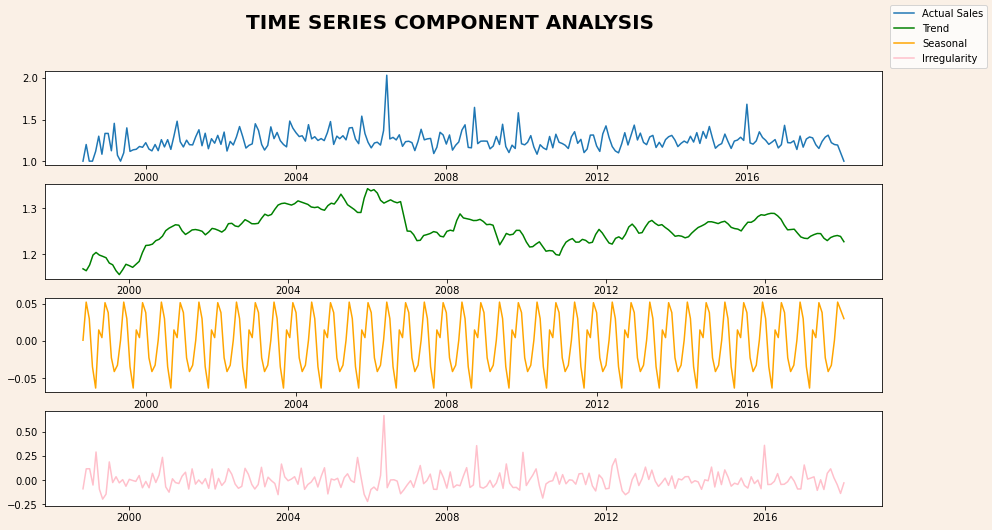

In [ ]:
tsa_comp(cd_pos)

### Checking stationarity

In [ ]:
checkStationarity(cd_pos)

pvalue: 5.12412343886656e-26


'Data is Stationary. Proceed to model building'

### Splitting the data

In [ ]:
ratio = 0.7
rows = int(ratio * len(cd_pos))
train1 =cd_pos[:rows]
test1 = cd_pos[rows:]

print("Total={}, Train={}, Test={}".format(len(cd_pos), len(train1), len(test1)))

Total=243, Train=170, Test=73


### PACF and ACF plots

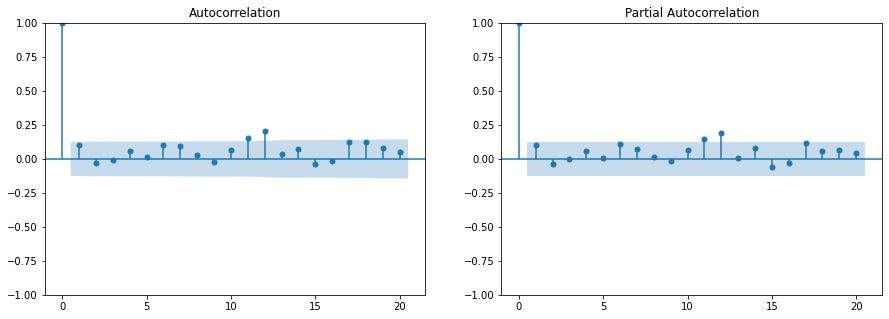

In [ ]:
p_and_q(cd_pos)

### creating models for different values of p and q

In [ ]:
d=0;
lis=[]
for p in range(3):
    for q in range(4):
        lis.append((p,d,q))

# building model
model=[]
for i in lis:
    m =ARIMA(train1, order=i).fit() 
    model.append(m)

# checking model is good or not
model_st=[]
c=1
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Good model
Model 7 Good model
Model 8 Good model
Model 9 Good model
Model 10 Good model
Model 11 Good model
Model 12 Good model


In [ ]:
aic=[]
bic=[]
for i in model[0:]:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in model[0:]:
    fcast = i.predict(start=len(train1), end=len(train1)+len(test1)-1)
    forecast.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test1, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# printing model numbers
model_no=[]
for i in range(0,len(model)):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results = pd.DataFrame({'Model No.': model_no, '(p, d, q)':lis[0:], 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 0, 0)",-223.452596,-217.181000,0.007941,0.089110
1,Model 1,"(0, 0, 1)",-223.833074,-214.425679,0.007908,0.088929
2,Model 2,"(0, 0, 2)",-221.955464,-209.412271,0.007917,0.088977
3,Model 3,"(0, 0, 3)",-219.962574,-204.283582,0.007914,0.088960
4,Model 4,"(1, 0, 0)",-223.654236,-214.246841,0.007907,0.088922
5,Model 5,"(1, 0, 1)",-221.926001,-209.382808,0.007915,0.088967
6,Model 6,"(1, 0, 2)",-219.956312,-204.277320,0.007917,0.088975
7,Model 7,"(1, 0, 3)",-225.786891,-206.972101,0.008051,0.089730
8,Model 8,"(2, 0, 0)",-221.966924,-209.423730,0.007914,0.088963
9,Model 9,"(2, 0, 1)",-219.986594,-204.307602,0.007918,0.088981


In [ ]:
print('Taking model with lowest RMSE score:')
df_results[df_results.RMSE==df_results.RMSE.min()]


Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
11,Model 11,"(2, 0, 3)",-227.070377,-205.119788,0.007848,0.088587


In [ ]:
print('Taking model with lowest BIC score:')

df_results[df_results.BIC==df_results.BIC.min()]

Taking model with lowest BIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 0, 0)",-223.452596,-217.181,0.007941,0.08911


In [ ]:
print('Taking model with lowest AIC score:')
df_results[df_results.AIC==df_results.AIC.min()]

Taking model with lowest AIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
11,Model 11,"(2, 0, 3)",-227.070377,-205.119788,0.007848,0.088587


### Modelling

In [ ]:
p=2;q=3;d=0
P=1;Q=1;D=0
m1 = sm.tsa.statespace.SARIMAX(cd_pos['sentiment_count'],order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
# summarise the model
m1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      sentiment_count   No. Observations:                  243
Model:             SARIMAX(2, 0, 3)x(1, 0, [1], 12)   Log Likelihood                 179.009
Date:                              Sun, 22 Jan 2023   AIC                           -342.018
Time:                                      08:55:06   BIC                           -314.073
Sample:                                           0   HQIC                          -330.762
                                              - 243                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1971      0.054      3.683      0.000       0.092       0.302
ar.L2          0.8028      0.055     14.490      0.000       0.694       0.911
ma.L1         -0.0998      0.046     -2.175      0.030      -0.190      -0.010
ma.L2         -0.7984      0.079    -10.072      0.000      -0.954      -0.643
ma.L3         -0.0919      0.082     -1.121      0.262      -0.253       0.069
ar.S.L12       0.9992      0.061     16.455      0.000       0.880       1.118
ma.S.L12      -0.9877      0.497     -1.986      0.047      -1.962      -0.013
sigma2         0.0124      0.005      2.468      0.014       0.003       0.022
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               746.17
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             1.83
Prob(H) (two-sided):                  0.07   Kurtosis:                        10.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m1.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [ ]:
start = len(train1) 
end = len(train1) + len(test1) - 1

print('start = {}, end = {}'.format(start,end))

start = 170, end = 242


In [ ]:
predictions = m1.predict(start,end)
predictions.index=test1.index
print(predictions)

date
2012-06-30    1.262712
2012-07-31    1.218697
2012-08-31    1.185215
2012-09-30    1.268885
2012-10-31    1.266120
                ...   
2018-02-28    1.234081
2018-03-31    1.242683
2018-04-30    1.248091
2018-05-31    1.282275
2018-07-31    1.257950
Name: predicted_mean, Length: 73, dtype: float64


In [ ]:
actual = []; pred = []
test1.reset_index(drop=True)
for i in range(len(predictions)):
    actual.append(test1['sentiment_count'][i])
    pred.append(predictions[i])

df_res1 = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res1['error'] = df_res1.actual - df_res1.predicted
df_res1.index=test1.index
print(df_res1)

              actual  predicted     error
date                                     
2012-06-30  1.122807   1.262712 -0.139905
2012-07-31  1.100000   1.218697 -0.118697
2012-08-31  1.208333   1.185215  0.023118
2012-09-30  1.342105   1.268885  0.073220
2012-10-31  1.194444   1.266120 -0.071676
...              ...        ...       ...
2018-02-28  1.312500   1.234081  0.078419
2018-03-31  1.222222   1.242683 -0.020461
2018-04-30  1.200000   1.248091 -0.048091
2018-05-31  1.193548   1.282275 -0.088727
2018-07-31  1.000000   1.257950 -0.257950

[73 rows x 3 columns]


In [ ]:
mse1=mean_squared_error(df_res1.actual,df_res1.predicted)
rmse1=np.sqrt(mse1)
print('mse:',mse1)
print('rmse:',rmse1)

mse: 0.008241401702643428
rmse: 0.09078216621475513


Text(0.5, 1.0, 'SARIMA Model. Order=(2,0,3)')

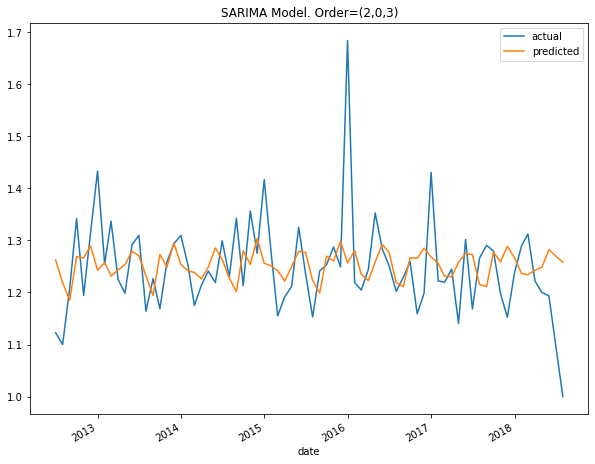

In [ ]:
msg = 'SARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
df_res1.actual.plot(figsize=(10,8),legend=True)
df_res1.predicted.plot(legend=True)
plt.title(msg)

In [ ]:
future_dates=pd.DataFrame()
future_dates['date']=['2018-06-30',    
'2018-07-31',    
'2018-08-31',  
'2018-09-30',  
'2018-10-31',    
'2018-11-30',   
'2018-12-31',    
'2019-01-31',    
'2019-02-28',  
'2019-03-31',   
'2019-04-30',    
'2019-05-31',    
'2019-06-30',  
'2019-07-31',    
'2019-08-31',   
'2019-09-30',  
'2019-10-31',   
'2019-11-30',    
'2019-12-31',    
'2020-01-31',  
'2020-02-29',    
'2020-03-31',   
'2020-04-30',   
'2020-05-31',   
'2020-06-30',   
'2020-07-31',    
'2020-08-31',   
'2020-09-30',  
'2020-10-31',    
'2020-11-30',    
'2020-12-31',    
'2021-01-31',    
'2021-02-28', 
'2021-03-31',    
'2021-04-30',   
'2021-05-31',   
'2021-06-30']      
future_dates=pd.to_datetime(future_dates['date'])
future_dates=pd.DataFrame(future_dates)


In [ ]:
fcast1 = m1.predict(start=len(cd_pos),end=len(cd_pos)+36).rename('Forecast')
fcast1.index=future_dates.date
print(fcast1.head())

date
2018-06-30    1.198773
2018-07-31    1.206711
2018-08-31    1.268204
2018-09-30    1.252776
2018-10-31    1.288348
Name: Forecast, dtype: float64


<AxesSubplot:xlabel='date', ylabel='count of positive sentiment'>

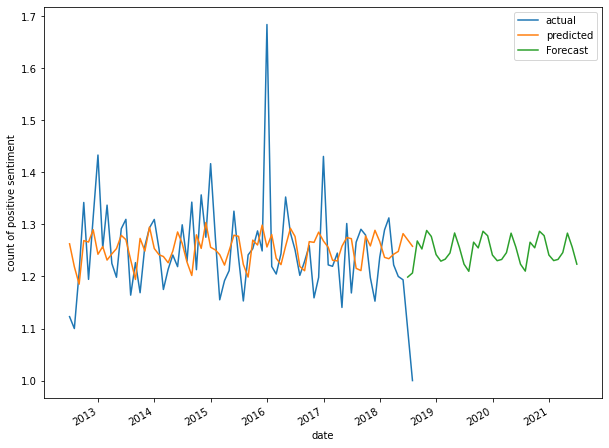

In [ ]:
df_res1.actual.plot(figsize=(10,8),legend=True)
df_res1.predicted.plot(legend=True)
plt.ylabel('count of positive sentiment')
fcast1.plot(legend=True)

## Neutral Sentiment

In [ ]:
df_cd_neu.head(3)

,reviewerID,asin,verified,review,ratings,date,summary,unixReviewTime,category,description,...,word_count,char_count,avg_word,polarity,label,year,rating_class_num,review_length,review_length_bin,Month
328318,A25G05CBB2GF09,B00003G1KQ,False,far compilations go acostas awake energetic li...,3.0,2000-07-06,"Better than many, not as good as some...",962841600,"['CDs & Vinyl', 'Dance & Electronic', 'Trance']","['Dubbed the It genre of 1999, trance music sa...",...,37,264,6.2,0.100000,0.0,2000,1,37,"(0, 100]",7
796322,A1KWPQ71V4DJ92,B00SJ9U1IU,True,song wanted hear,3.0,2017-08-15,Three Stars,1502755200,"['CDs & Vinyl', 'Christian', 'Pop & Contempora...","['ANY GIVEN SUNDAY, the sophomore release to t...",...,3,16,4.7,0.000000,0.0,2017,1,3,"(0, 100]",8
148822,A3T9IX8EDFDX4G,B000002J5Z,False,foreigners fifth studio album agent provocateu...,3.0,2012-10-07,Decent Foreigner album,1349568000,"['CDs & Vinyl', 'Classic Rock', 'Album-Oriente...",['Certified at 3 million units by the RIAA. (2...,...,102,664,5.6,0.250289,0.0,2012,1,100,"(0, 100]",10


In [ ]:
cd_neu_count=df_cd_neu.groupby(['asin','Month','Sentiment']).size().reset_index(name='sentiment_count')
cd_neu_count

,asin,Month,Sentiment,sentiment_count
0,0005164885,2,Neutral,2
1,0967680654,1,Neutral,1
2,1566054109,6,Neutral,2
3,1858703883,6,Neutral,1
4,1858704553,2,Neutral,1
...,...,...,...,...
25439,B01HE8WDP0,6,Neutral,2
25440,B01HEYDFJC,10,Neutral,1
25441,B01HHV3R5O,10,Neutral,1
25442,B01HIDRZWM,8,Neutral,1


In [ ]:
cd_neu=pd.merge(df_cd_neu,cd_neu_count)

In [ ]:
cd_neu=cd_neu[['date','sentiment_count']]
cd_neu=cd_neu.set_index('date')
cd_neu=cd_neu.sort_values(by=['date'])
cd_neu

,sentiment_count
date,
1998-05-27,2
1998-05-27,2
1998-06-03,1
1998-06-13,1
1998-06-15,2
...,...
2018-05-14,1
2018-05-14,1
2018-05-14,1


In [ ]:
cd_neu=cd_neu.resample('M').mean()
cd_neu.head()

,sentiment_count
date,
1998-05-31,2.000000
1998-06-30,1.428571
1998-07-31,1.428571
1998-08-31,1.800000
1998-09-30,1.444444


In [ ]:
cd_neu.isnull().sum()

sentiment_count    1
dtype: int64

In [ ]:
cd_neu.dropna(inplace=True)

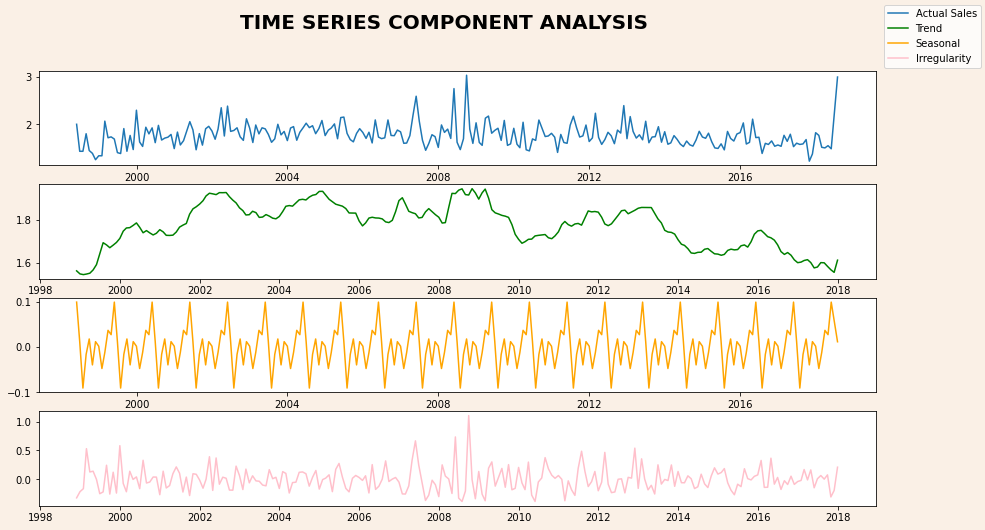

In [ ]:
tsa_comp(cd_neu)

In [ ]:
checkStationarity(cd_neu)

pvalue: 9.202811926219588e-07


'Data is Stationary. Proceed to model building'

In [ ]:
diff_cd_neu = cd_neu-cd_neu.shift(1)
print(diff_cd_neu)

            sentiment_count
date                       
1998-05-31              NaN
1998-06-30        -0.571429
1998-07-31         0.000000
1998-08-31         0.371429
1998-09-30        -0.355556
...                     ...
2018-02-28        -0.251192
2018-03-31        -0.013514
2018-04-30         0.047170
2018-05-31        -0.065688
2018-07-31         1.518519

[242 rows x 1 columns]


In [ ]:
diff_cd_neu.dropna(inplace=True)

In [ ]:
checkStationarity(diff_cd_neu)

pvalue: 3.2785178334525948e-12


'Data is Stationary. Proceed to model building'

In [ ]:
ratio = 0.7
rows = int(ratio * len(cd_neu))
train2 =cd_neu[:rows]
test2 = cd_neu[rows:]

print("Total={}, Train={}, Test={}".format(len(cd_neu), len(train2), len(test2)))

Total=242, Train=169, Test=73


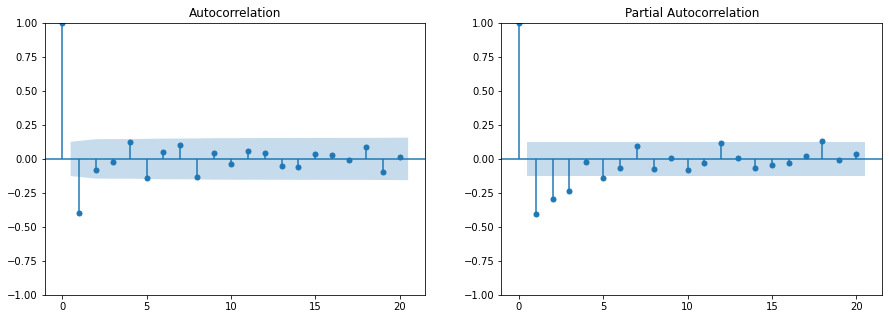

In [ ]:
p_and_q(diff_cd_neu)

In [ ]:
d=1;
lis=[]
for p in range(8):
    for q in range(5):
        lis.append((p,d,q))

# building model
model=[]
for i in lis:
    m =ARIMA(train2, order=i).fit() 
    model.append(m)

# checking model is good or not
model_st=[]
c=1
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Not a good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Not a good model
Model 7 Good model
Model 8 Good model
Model 9 Good model
Model 10 Good model
Model 11 Not a good model
Model 12 Good model
Model 13 Good model
Model 14 Good model
Model 15 Good model
Model 16 Good model
Model 17 Good model
Model 18 Good model
Model 19 Good model
Model 20 Good model
Model 21 Good model
Model 22 Good model
Model 23 Good model
Model 24 Good model
Model 25 Good model
Model 26 Good model
Model 27 Good model
Model 28 Good model
Model 29 Good model
Model 30 Good model
Model 31 Good model
Model 32 Good model
Model 33 Good model
Model 34 Good model
Model 35 Good model
Model 36 Good model
Model 37 Good model
Model 38 Good model
Model 39 Good model
Model 40 Good model


In [ ]:
aic=[]
bic=[]
for i in model[0:]:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in model[0:]:
    fcast = i.predict(start=len(train2), end=len(train2)+len(test2)-1)
    forecast.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test2, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# printing model numbers
model_no=[]
for i in range(0,len(model)):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results2 = pd.DataFrame({'Model No.': model_no, '(p, d, q)':lis[0:], 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results2

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 1, 0)",114.830486,117.954450,0.057938,0.240703
1,Model 1,"(0, 1, 1)",17.860564,24.108492,0.063845,0.252676
2,Model 2,"(0, 1, 2)",19.703849,29.075741,0.063976,0.252935
3,Model 3,"(0, 1, 3)",19.243575,31.739431,0.063942,0.252868
4,Model 4,"(0, 1, 4)",20.674859,36.294679,0.064451,0.253872
5,Model 5,"(1, 1, 0)",84.395602,90.643530,0.060528,0.246024
6,Model 6,"(1, 1, 1)",19.747299,29.119191,0.063939,0.252861
7,Model 7,"(1, 1, 2)",21.728435,34.224291,0.063622,0.252235
8,Model 8,"(1, 1, 3)",20.992151,36.611970,0.064181,0.253340
9,Model 9,"(1, 1, 4)",20.201752,38.945535,0.064908,0.254770


In [ ]:
print('Taking model with lowest RMSE score:')
df_results2[df_results2.RMSE==df_results2.RMSE.min()]


Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
15,Model 15,"(3, 1, 0)",43.249444,55.7453,0.057594,0.239988


In [ ]:
print('Taking model with lowest BIC score:')

df_results2[df_results2.BIC==df_results2.BIC.min()]

Taking model with lowest BIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
1,Model 1,"(0, 1, 1)",17.860564,24.108492,0.063845,0.252676


In [ ]:
print('Taking model with lowest AIC score:')
df_results2[df_results2.AIC==df_results2.AIC.min()]

Taking model with lowest AIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
13,Model 13,"(2, 1, 3)",11.911292,30.655075,0.063915,0.252814


In [ ]:
p=2;q=3;d=1
P=1;Q=1;D=1
m2 = sm.tsa.statespace.SARIMAX(cd_neu['sentiment_count'],order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
# summarise the model
m2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      sentiment_count   No. Observations:                  242
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 12)   Log Likelihood                 -17.543
Date:                              Sun, 22 Jan 2023   AIC                             51.085
Time:                                      08:56:04   BIC                             78.555
Sample:                                           0   HQIC                            62.167
                                              - 242                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1713      0.057    -20.699      0.000      -1.282      -1.060
ar.L2         -0.9237      0.046    -20.238      0.000      -1.013      -0.834
ma.L1          0.3370      0.054      6.248      0.000       0.231       0.443
ma.L2         -0.2089      0.053     -3.960      0.000      -0.312      -0.106
ma.L3         -0.9203      0.052    -17.795      0.000      -1.022      -0.819
ar.S.L12      -0.0355      0.089     -0.400      0.689      -0.210       0.139
ma.S.L12      -0.8383      0.081    -10.304      0.000      -0.998      -0.679
sigma2         0.0620      0.006     11.182      0.000       0.051       0.073
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):               368.11
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             1.45
Prob(H) (two-sided):                  0.20   Kurtosis:                         8.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m2.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [ ]:
start = len(train2) 
end = len(train2) + len(test2) - 1

print('start = {}, end = {}'.format(start,end))

start = 169, end = 241


In [ ]:
predictions = m2.predict(start,end)
predictions.index=test2.index
print(predictions)

date
2012-06-30    1.759863
2012-07-31    1.748687
2012-08-31    1.838099
2012-09-30    1.806580
2012-10-31    1.761889
                ...   
2018-02-28    1.498510
2018-03-31    1.690847
2018-04-30    1.621527
2018-05-31    1.503314
2018-07-31    1.687460
Name: predicted_mean, Length: 73, dtype: float64


In [ ]:
actual = []; pred = []
for i in range(len(predictions)):
    actual.append(test2['sentiment_count'][i])
    pred.append(predictions[i])

df_res2 = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res2['error'] = df_res2.actual - df_res2.predicted
df_res2.index=test2.index
print(df_res2)

              actual  predicted     error
date                                     
2012-06-30  1.830357   1.759863  0.070494
2012-07-31  1.756757   1.748687  0.008070
2012-08-31  1.589286   1.838099 -0.248813
2012-09-30  1.877358   1.806580  0.070778
2012-10-31  1.814159   1.761889  0.052270
...              ...        ...       ...
2018-02-28  1.513514   1.498510  0.015003
2018-03-31  1.500000   1.690847 -0.190847
2018-04-30  1.547170   1.621527 -0.074357
2018-05-31  1.481481   1.503314 -0.021833
2018-07-31  3.000000   1.687460  1.312540

[73 rows x 3 columns]


In [ ]:
mse2=mean_squared_error(df_res2.actual,df_res2.predicted)
rmse2=np.sqrt(mse2)
print('mse:',mse2)
print('rmse:',rmse2)

mse: 0.06073917886903217
rmse: 0.24645319813106945


Text(0.5, 1.0, 'SARIMA Model. Order=(2,1,3)')

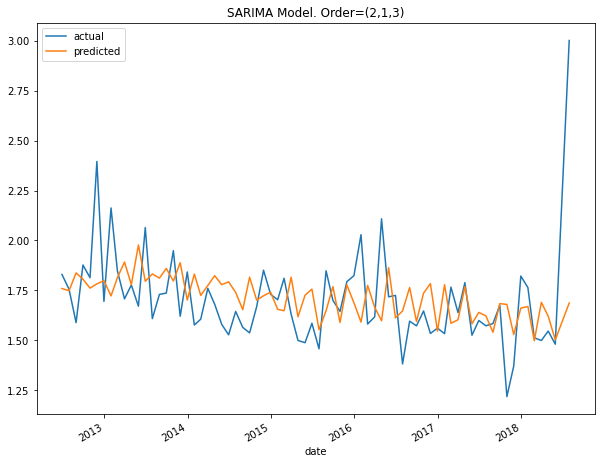

In [ ]:
msg = 'SARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
df_res2.actual.plot(figsize=(10,8),legend=True)
df_res2.predicted.plot(legend=True)
plt.title(msg)

In [ ]:
fcast2 = m2.predict(start=len(cd_neu),end=len(cd_neu)+36).rename('Forecast')
fcast2.index=future_dates.date
print(fcast2.head())

date
2018-06-30    1.654255
2018-07-31    1.539762
2018-08-31    1.738438
2018-09-30    1.650834
2018-10-31    1.575357
Name: Forecast, dtype: float64


<AxesSubplot:xlabel='date', ylabel='count of neutral sentiment'>

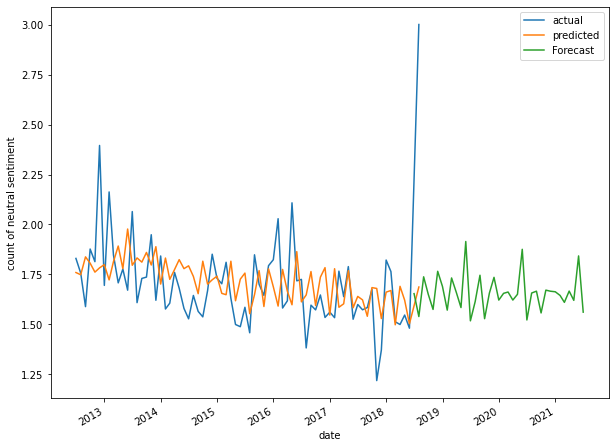

In [ ]:
df_res2.actual.plot(figsize=(10,8),legend=True)
df_res2.predicted.plot(legend=True)
plt.ylabel('count of neutral sentiment')
fcast2.plot(legend=True)

## Negative

In [ ]:
cd_neg_count=df_cd_neg.groupby(['asin','Month','Sentiment']).size().reset_index(name='sentiment_count')
cd_neg_count

,asin,Month,Sentiment,sentiment_count
0,0005164885,1,Negative,1
1,0005164885,7,Negative,1
2,1570195013,9,Negative,1
3,1858703883,4,Negative,2
4,1858703883,7,Negative,1
...,...,...,...,...
22225,B01HCEBIMU,11,Negative,1
22226,B01HCR8QWW,10,Negative,1
22227,B01HE3JKEW,10,Negative,1
22228,B01HEYDFJC,11,Negative,1


In [ ]:
cd_neg=pd.merge(df_cd_neg,cd_neg_count)

In [ ]:
cd_neg=cd_neg[['date','sentiment_count']]
cd_neg=cd_neg.set_index('date')
cd_neg=cd_neg.sort_values(by=['date'])
cd_neg

,sentiment_count
date,
1997-12-31,1
1998-05-15,1
1998-05-15,1
1998-05-25,1
1998-05-31,1
...,...
2018-05-16,2
2018-05-16,2
2018-05-16,2


In [ ]:
cd_neg=cd_neg.resample('M').mean()
cd_neg.head()

,sentiment_count
date,
1997-12-31,1.0
1998-01-31,NaN
1998-02-28,NaN
1998-03-31,NaN
1998-04-30,NaN


In [ ]:
cd_neg.isnull().sum()

sentiment_count    4
dtype: int64

In [ ]:
cd_neg.dropna(inplace=True)

In [ ]:
checkStationarity(cd_neg)

pvalue: 0.19707593379880184


' Data is not Stationary. Make the data stationary before model building'

In [ ]:
diff_cd_neg = cd_neg-cd_neg.shift(1)
print(diff_cd_neg)

            sentiment_count
date                       
1997-12-31              NaN
1998-05-31         0.000000
1998-06-30         0.142857
1998-07-31         0.790476
1998-08-31        -0.433333
...                     ...
2018-02-28        -0.171395
2018-03-31         0.206349
2018-04-30        -0.296992
2018-05-31         0.024671
2018-06-30        -0.656250

[243 rows x 1 columns]


In [ ]:
diff_cd_neg.dropna(inplace=True)

In [ ]:
checkStationarity(diff_cd_neg)

pvalue: 1.9276743512147565e-09


'Data is Stationary. Proceed to model building'

In [ ]:
ratio = 0.7
rows = int(ratio * len(cd_neg))
train3 =cd_neg[:rows]
test3 = cd_neg[rows:]

print("Total={}, Train={}, Test={}".format(len(cd_neg), len(train3), len(test3)))

Total=243, Train=170, Test=73


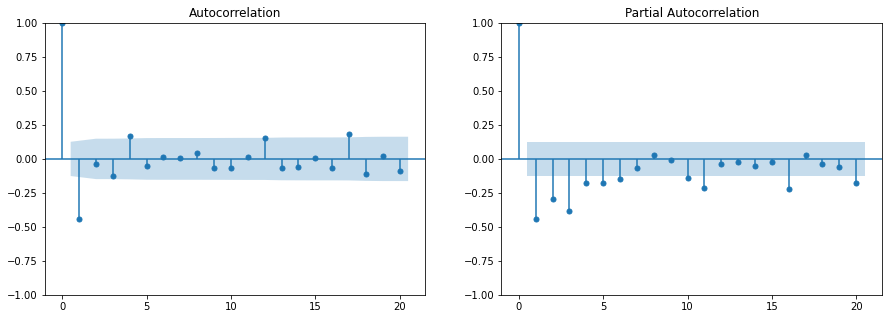

In [ ]:
p_and_q(diff_cd_neg)

In [ ]:
d=1;
lis=[]
for p in range(8):
    for q in range(4):
        lis.append((p,d,q))

# building model
model=[]
for i in lis:
    m =ARIMA(train3, order=i).fit() 
    model.append(m)

# checking model is good or not
model_st=[]
c=1
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Not a good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Good model
Model 7 Good model
Model 8 Good model
Model 9 Good model
Model 10 Good model
Model 11 Good model
Model 12 Good model
Model 13 Good model
Model 14 Good model
Model 15 Good model
Model 16 Good model
Model 17 Good model
Model 18 Good model
Model 19 Good model
Model 20 Good model
Model 21 Good model
Model 22 Good model
Model 23 Good model
Model 24 Good model
Model 25 Good model
Model 26 Good model
Model 27 Good model
Model 28 Good model
Model 29 Good model
Model 30 Good model
Model 31 Good model
Model 32 Good model


In [ ]:
aic=[]
bic=[]
for i in model[0:]:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in model[0:]:
    fcast = i.predict(start=len(train3), end=len(train3)+len(test3)-1)
    forecast.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test3, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# printing model numbers
model_no=[]
for i in range(0,len(model)):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results3 = pd.DataFrame({'Model No.': model_no, '(p, d, q)':lis[0:], 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results3

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 1, 0)",505.170647,508.300545,0.508429,0.713042
1,Model 1,"(0, 1, 1)",414.770278,421.030075,0.792044,0.889969
2,Model 2,"(0, 1, 2)",416.231216,425.620912,0.779501,0.882894
3,Model 3,"(0, 1, 3)",417.396938,429.916533,0.809705,0.899836
4,Model 4,"(1, 1, 0)",473.221326,479.481123,0.418682,0.647056
5,Model 5,"(1, 1, 1)",416.329298,425.718994,0.780520,0.883470
6,Model 6,"(1, 1, 2)",418.066326,430.585921,0.782769,0.884742
7,Model 7,"(1, 1, 3)",418.979771,434.629265,0.837650,0.915232
8,Model 8,"(2, 1, 0)",457.494257,466.883953,0.452603,0.672758
9,Model 9,"(2, 1, 1)",416.829501,429.349096,0.816654,0.903689


In [ ]:
print('Taking model with lowest RMSE score:')
df_results3[df_results3.RMSE==df_results3.RMSE.min()]


Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
4,Model 4,"(1, 1, 0)",473.221326,479.481123,0.418682,0.647056


In [ ]:
print('Taking model with lowest BIC score:')

df_results3[df_results3.BIC==df_results3.BIC.min()]

Taking model with lowest BIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
1,Model 1,"(0, 1, 1)",414.770278,421.030075,0.792044,0.889969


In [ ]:
print('Taking model with lowest AIC score:')
df_results3[df_results3.AIC==df_results3.AIC.min()]

Taking model with lowest AIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
11,Model 11,"(2, 1, 3)",410.257174,429.036566,0.804646,0.897021


In [ ]:
p=2;q=3;d=1
P=1;Q=1;D=1
m3 = sm.tsa.statespace.SARIMAX(cd_neg['sentiment_count'],order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
# summarise the model
m3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      sentiment_count   No. Observations:                  243
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 12)   Log Likelihood                -267.908
Date:                              Sun, 22 Jan 2023   AIC                            551.816
Time:                                      08:57:01   BIC                            579.321
Sample:                                           0   HQIC                           562.911
                                              - 243                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4894      0.089    -16.689      0.000      -1.664      -1.314
ar.L2         -0.9240      0.077    -12.050      0.000      -1.074      -0.774
ma.L1          0.6244      0.073      8.533      0.000       0.481       0.768
ma.L2         -0.3916      0.058     -6.753      0.000      -0.505      -0.278
ma.L3         -0.8744      0.052    -16.918      0.000      -0.976      -0.773
ar.S.L12       0.0638      0.093      0.684      0.494      -0.119       0.247
ma.S.L12      -0.9998     41.972     -0.024      0.981     -83.263      81.264
sigma2         0.5112     21.435      0.024      0.981     -41.500      42.523
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              2497.68
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             3.11
Prob(H) (two-sided):                  0.88   Kurtosis:                        17.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m3.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [ ]:
start = len(train3) 
end = len(train3) + len(test3) - 1

print('start = {}, end = {}'.format(start,end))

start = 170, end = 242


In [ ]:
predictions = m3.predict(start,end)
predictions.index=test3.index
print(predictions)

date
2012-06-30    3.017437
2012-07-31    2.702513
2012-08-31    2.548413
2012-09-30    2.526526
2012-10-31    2.575371
                ...   
2018-02-28    1.591891
2018-03-31    1.977651
2018-04-30    1.803353
2018-05-31    1.760808
2018-06-30    1.618708
Name: predicted_mean, Length: 73, dtype: float64


In [ ]:
actual = []; pred = []
for i in range(len(predictions)):
    actual.append(test3['sentiment_count'][i])
    pred.append(predictions[i])

df_res3 = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res3['error'] = df_res3.actual - df_res3.predicted
df_res3.index=test3.index
print(df_res3)

              actual  predicted     error
date                                     
2012-06-30  1.931298   3.017437 -1.086139
2012-07-31  2.317073   2.702513 -0.385440
2012-08-31  1.590909   2.548413 -0.957504
2012-09-30  2.260870   2.526526 -0.265656
2012-10-31  2.810811   2.575371  0.235440
...              ...        ...       ...
2018-02-28  1.722222   1.591891  0.130331
2018-03-31  1.928571   1.977651 -0.049079
2018-04-30  1.631579   1.803353 -0.171774
2018-05-31  1.656250   1.760808 -0.104558
2018-06-30  1.000000   1.618708 -0.618708

[73 rows x 3 columns]


In [ ]:
mse3=mean_squared_error(df_res3.actual,df_res3.predicted)
rmse3=np.sqrt(mse3)
print('mse:',mse3)
print('rmse:',rmse3)

mse: 0.35314138309754745
rmse: 0.594257000882234


Text(0.5, 1.0, 'SARIMA Model. Order=(2,1,3)')

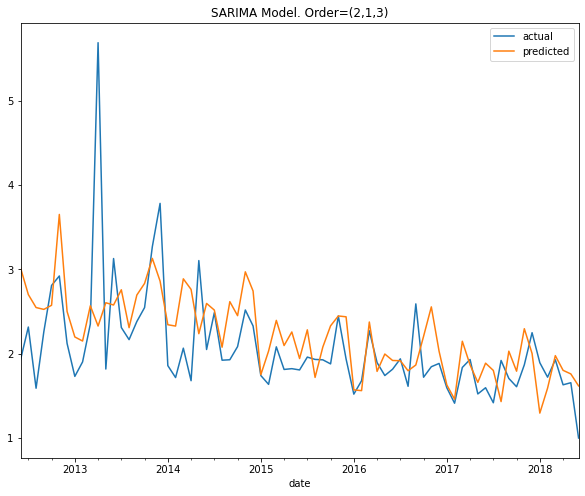

In [ ]:
msg = 'SARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
df_res3.actual.plot(figsize=(10,8),legend=True)
df_res3.predicted.plot(legend=True)
plt.title(msg)

In [ ]:
fcast3 = m3.predict(start=len(cd_neg),end=len(cd_neg)+36).rename('Forecast')
fcast3.index=future_dates.date
print(fcast3.head())

date
2018-06-30    1.818342
2018-07-31    1.409346
2018-08-31    1.790627
2018-09-30    1.862968
2018-10-31    2.132692
Name: Forecast, dtype: float64


<AxesSubplot:xlabel='date', ylabel='count of negative sentiment'>

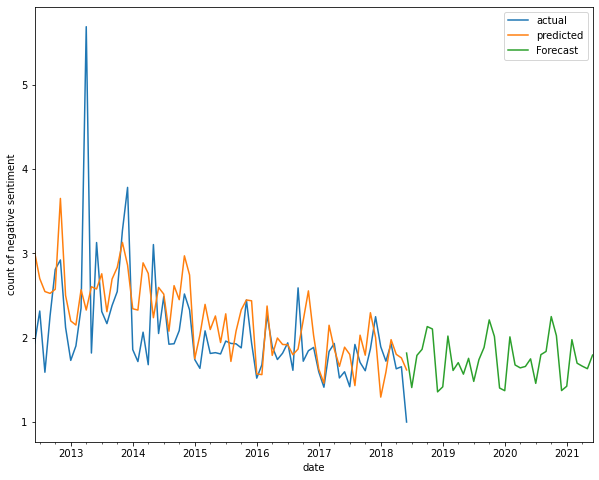

In [ ]:
df_res3.actual.plot(figsize=(10,8),legend=True)
df_res3.predicted.plot(legend=True)
plt.ylabel('count of negative sentiment')
fcast3.plot(legend=True)